## Objective

This notebook will get you started with training the benchmark object detection model for detecting the potholes. 

* Download the training dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/train-file
* Download the test dataset: https://datahack.analyticsvidhya.com/contest/dataverse-hack/download/test-file

**Note**: 

1. We recommend you to run the notebook on google colab since it is developed on the google colab.

2. Ensure to add the appropriate path names to read the image names and annotation files if you are running locally.

3. Change the runtime to GPU for quick results.


**Steps to Implement Faster RCNN**

1. Import requires libraries and load data
2. Data Preprocessing
3. Defining model architecture
4. Testing the model

**Import Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches
%matplotlib inline
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the data 
!unzip '/content/drive/MyDrive/Colab Notebooks/AV Dataverse/train.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/AV Dataverse/train.zip
   creating: train/
  inflating: train/labels.csv        
   creating: train/images/
  inflating: train/images/304.jpg    
  inflating: train/images/343.jpg    
  inflating: train/images/672.jpg    
  inflating: train/images/129.jpg    
  inflating: train/images/488.jpg    
  inflating: train/images/427.jpg    
  inflating: train/images/287.jpg    
  inflating: train/images/467.jpg    
  inflating: train/images/121.jpg    
  inflating: train/images/633.jpg    
  inflating: train/images/581.jpg    
  inflating: train/images/649.jpg    
  inflating: train/images/339.jpg    
  inflating: train/images/185.jpg    
  inflating: train/images/527.jpg    
  inflating: train/images/76.jpg     
  inflating: train/images/487.jpg    
  inflating: train/images/295.jpg    
  inflating: train/images/582.jpg    
  inflating: train/images/208.jpg    
  inflating: train/images/671.jpg    
  inflating: train/images/257.jpg    
  infla

In [ ]:
#!unzip 
!unzip '/content/drive/MyDrive/Colab Notebooks/AV Dataverse/test_niF99zC.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/AV Dataverse/test_niF99zC.zip
   creating: test/
   creating: test/images/
  inflating: test/images/900.jpg     
  inflating: test/images/1014.jpg    
  inflating: test/images/1067.jpg    
  inflating: test/images/1000.jpg    
  inflating: test/images/798.jpg     
  inflating: test/images/816.jpg     
  inflating: test/images/1054.jpg    
  inflating: test/images/1129.jpg    
  inflating: test/images/1032.jpg    
  inflating: test/images/860.jpg     
  inflating: test/images/1097.jpg    
  inflating: test/images/1114.jpg    
  inflating: test/images/1047.jpg    
  inflating: test/images/1011.jpg    
  inflating: test/images/995.jpg     
  inflating: test/images/873.jpg     
  inflating: test/images/838.jpg     
  inflating: test/images/867.jpg     
  inflating: test/images/716.jpg     
  inflating: test/images/956.jpg     
  inflating: test/images/1151.jpg    
  inflating: test/images/700.jpg     
  inflating: test/images/1216.jpg    
  

**Data Preprocessing**

In [ ]:
# reading csv file
data = pd.read_csv('/content/train/labels.csv')
data.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,1.jpg,pothole,0,131,140,263
1,1.jpg,pothole,168,487,279,449
2,1.jpg,pothole,1,144,34,109
3,2.jpg,pothole,57,952,271,505
4,3.jpg,pothole,225,416,292,439


In [ ]:
data['LabelName'] = data['LabelName'].replace({'pothole': 1})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])

In [ ]:
# defining class to load data
class PotHoleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None,train=True):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = os.listdir(root)
        if '.ipynb_checkpoints' in self.imgs:
          self.imgs.remove('.ipynb_checkpoints')
        self.train = train

    def __getitem__(self, idx):
        # load images

        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)
        if self.train == False:
          if self.transforms is not None:
            img = self.transforms(img)
          return img,img_name
        else:
          h, w = np.array(img).shape[:2]
          num_objs = data[data['ImageID'] == img_name].shape[0]
          boxes = []
          cell_type = []
          for i in range(num_objs):
              xmin = data[data['ImageID'] == img_name]['XMin'].iloc[i]
              xmax = data[data['ImageID'] == img_name]['XMax'].iloc[i]
              ymin = data[data['ImageID'] == img_name]['YMin'].iloc[i]
              ymax = data[data['ImageID'] == img_name]['YMax'].iloc[i]
              target = data[data['ImageID'] == img_name]['LabelName'].iloc[i]
              boxes.append([xmin, ymin, xmax, ymax])
              cell_type.append(target)
          # convert everything into a torch.Tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels = torch.as_tensor(cell_type, dtype=torch.int64)

          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          #print(boxes)
          if self.transforms is not None:
              img = self.transforms(img)
              boxes[:, 0] = boxes[:, 0] * (224/w)
              boxes[:, 2] = boxes[:, 2] * (224/w)
              boxes[:, 1] = boxes[:, 1] * (224/h)
              boxes[:, 3] = boxes[:, 3] * (224/h)

          return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PotHoleDataset('/content/train/images/', transforms=transform)

In [ ]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [ ]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [ ]:
batch_x[0].shape

torch.Size([3, 224, 224])

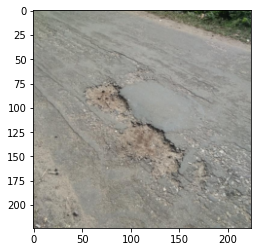

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

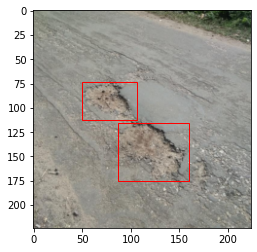

In [ ]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]
    if batch_y[0]['labels'][i] == 1:
        color = 'red'

    rectangle = matplotlib.patches.Rectangle((x1,y1), x2-x1, y2-y1,fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()


**Defining the model**

In [ ]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:

# check model on one image
model.eval()
output = model(batch_x[5].view(1, 3, 224, 224))

In [ ]:
output

[{'boxes': tensor([[7.5335e+01, 8.0266e+01, 8.3662e+01, 8.6131e+01],
          [7.2082e+01, 8.1191e+01, 8.0557e+01, 8.8552e+01],
          [3.6386e+01, 4.5305e+01, 8.2291e+01, 5.3588e+01],
          [6.7089e+01, 8.2950e+01, 8.4911e+01, 1.0112e+02],
          [3.3676e+00, 2.0590e+00, 1.4580e+02, 2.9437e+01],
          [8.0272e+01, 7.4673e+01, 1.1943e+02, 1.1167e+02],
          [5.4843e+01, 8.6136e+01, 6.6668e+01, 9.6876e+01],
          [7.5033e+01, 9.1205e+01, 8.2785e+01, 9.8945e+01],
          [2.2120e+02, 1.0530e-01, 2.2400e+02, 2.7453e+00],
          [1.0793e+02, 5.5926e+01, 2.1359e+02, 1.6327e+02],
          [3.2329e+01, 4.5227e+01, 1.0811e+02, 6.3646e+01],
          [2.1605e+02, 1.3734e-01, 2.2395e+02, 3.8000e+00],
          [7.5502e+01, 1.0756e+02, 1.1445e+02, 1.4827e+02],
          [1.4504e+02, 5.0232e+01, 1.9946e+02, 1.6874e+02],
          [6.0597e+01, 9.2356e+01, 1.2276e+02, 2.0092e+02],
          [3.6127e+01, 7.1176e-01, 2.1630e+02, 1.4508e+01],
          [8.0656e-02, 8.5930e+

In [ ]:
#GPU if avilable
model = model.to(device)

In [ ]:
# define optimization 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(2):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU if available
        batch_x = list(image.to(device) for image in batch_x)
        batch_y = [{k: v.to(device) for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.12263712282566464 for classification and 0.1552898967090775 for regression 
Training loss for epoch 2 is 0.08262662028565126 for classification and 0.12870365188402288 for regression 


**Model Evaluation**

In [ ]:
test_dataset = PotHoleDataset('/content/test/images/', transforms=transform,train=False)

In [ ]:
# defining data loader
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False
)

In [ ]:
my_submission = pd.DataFrame()
model.eval()
for batch_test,names in data_loader_test:
  output = model(batch_test.to(device))
  output = [{k: v.to("cpu") for k, v in t.items()} for t in output]
  temp = pd.DataFrame()
  for i in range(len(output)):
    boxes = output[i]['boxes'].detach().numpy()
    scores = output[i]['scores'].detach().numpy()
    labels = output[i]['labels'].detach().numpy()
    scores = np.expand_dims(scores, axis=1)
    labels = np.expand_dims(labels, axis=1)
    batch_df = pd.DataFrame(np.hstack((boxes,scores,labels)),columns=['XMin','YMin','XMax','YMax','Conf','LabelName'])
    batch_df['ImageID'] = names[i]
    img = cv2.imread('/content/test/images/'+names[i])
    h,w = img.shape[:2]
    batch_df['LabelName'] = 'pothole'
    batch_df['XMax'] = batch_df['XMax']/224 * w
    batch_df['XMin'] = batch_df['XMin']/224 * w
    batch_df['YMax'] = batch_df['YMax']/224 * h
    batch_df['YMin'] = batch_df['YMin']/224 * h
    batch_df['XMax'] = batch_df['XMax'].astype(int)
    batch_df['XMin'] = batch_df['XMin'].astype(int)
    batch_df['YMax'] = batch_df['YMax'].astype(int)
    batch_df['YMin'] = batch_df['YMin'].astype(int)
    temp = pd.concat([batch_df,temp])
  my_submission = pd.concat([my_submission,temp])

In [ ]:
my_submission.to_csv('2_epoch.csv',index=False)

In [ ]:
from google.colab import files
files.download('2_epoch.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>